# Using Autocorrelation to Evaluate Models (Lorentz)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import kstest
import pysindy as ps
import statsmodels.graphics.tsaplots as sgt

np.random.seed(100)

### Define Lorenz System:

In [2]:
sigma = 6
rho = 19
beta = 8/3

def lorenz(t, x):
    return [
        sigma*(x[1] - x[0]),
        x[0]*(rho - x[2]) - x[1],
        x[0]*x[1] - beta*x[2]
    ]

### Create Training Data:

In [3]:
dt = 0.001  # Timestep

# First trajectory:
t_train1 = np.arange(0,10,dt)  # Time range to integrate over
x0_train1 = [-1,1,-1]  # Initial conditions
sol1 = solve_ivp(lorenz, (t_train1[0], t_train1[-1]), x0_train1, t_eval=t_train1)  # Integrate to produce x(t),y(t),z(t)
x_train1 = np.transpose(sol1.y)  
print(x_train1)

# Second trajectory:
t_train2 = np.arange(100,110,dt)  # Time range to integrate over
x0_train2 = [2,-2,2]  # Initial conditions
sol2 = solve_ivp(lorenz, (t_train2[0], t_train2[-1]), x0_train2, t_eval=t_train2) # Integrate to produce x(t),y(t),z(t)
x_train2 = np.transpose(sol2.y)  

# Add noise to both our trajectories:
x_train1 += np.random.normal(scale = 0.05, size=x_train1.shape) 
x_train2 += np.random.normal(scale = 0.05, size=x_train2.shape) 

# Combine both trajectory data sets into a list:
x_train = [x_train1, x_train2]

[[-1.          1.         -1.        ]
 [-0.98418183  0.97024444 -0.99831328]
 [-0.96872314  0.94097092 -0.99658753]
 ...
 [ 5.90940069  8.72105705 18.97951931]
 [ 5.93200061  8.76568766 18.98066806]
 [ 5.95476458  8.81048981 18.98228021]]


### Create SINDy Model:

In [4]:
stlsq_opt = ps.STLSQ(threshold = 0.1) # Set threshold
model = ps.SINDy(optimizer=stlsq_opt)
model.fit(x_train, t=dt, multiple_trajectories=True)
model.print()

x0' = -7.995 x0 + 8.001 x1
x1' = 27.854 x0 + -0.976 x1 + -0.995 x0 x2
x2' = -2.667 x2 + 0.999 x0 x1


### Create test trajectory:

In [5]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)  # Longer time range
x0_test = np.array([8, 7, 15])  # New initial conditions
sol = solve_ivp(lorenz, (t_test[0], t_test[-1]), x0_test, t_eval=t_test) # Integrate to produce x(t),y(t),z(t)
x_test = np.transpose(sol.y)  

print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.999937


### Simulate forward in time

In [6]:
x_test_sim = model.simulate(x0_test, t_test)
len(x_test_sim)

15000

[Text(0.5, 0, '$x_0$'),
 Text(0.5, 0, '$x_1$'),
 Text(0.5, 0, '$x_2$'),
 Text(0.5, 0.92, 'model simulation')]

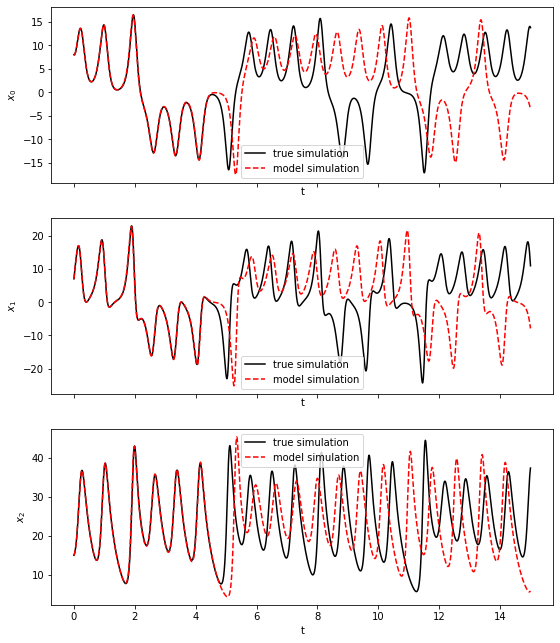

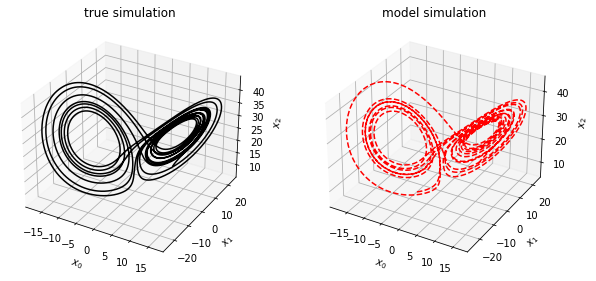

In [10]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(9,11))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))
    
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')


ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

In [15]:
diff = np.zeros(t_test.size)

for i in range(t_test.size):
    diff[i] = np.linalg.norm(x_test[i]-x_test_sim[i])
    
print(diff)

[0.00000000e+00 3.94715948e-04 7.86779968e-04 ... 4.07360954e+01
 4.07418485e+01 4.07454144e+01]


### compare autocorrelation functions of actual and predicted data (one dimension)

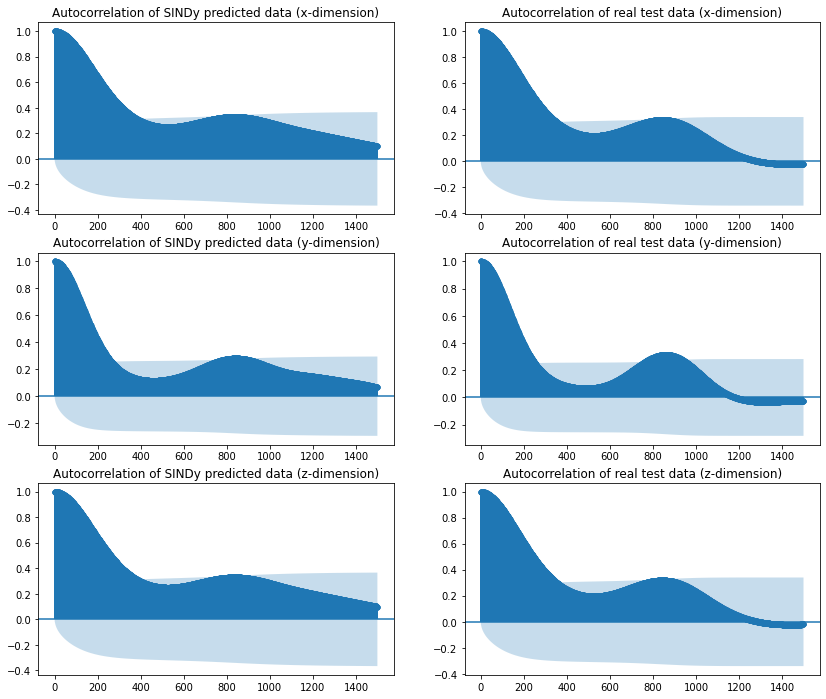

In [8]:
fig, axs = plt.subplots(3,2, figsize=(14,12))
num_lags = np.arange(0,len(x_test_sim)/10,1)
sgt.plot_acf(x_test_sim[:,0], ax=axs[0,0], lags=num_lags, title='Autocorrelation of SINDy predicted data (x-dimension)')
sgt.plot_acf(x_test[:,0], ax= axs[0,1], lags=num_lags, title='Autocorrelation of real test data (x-dimension)')

sgt.plot_acf(x_test_sim[:,1], ax=axs[1,0], lags=num_lags, title='Autocorrelation of SINDy predicted data (y-dimension)')
sgt.plot_acf(x_test[:,1], ax=axs[1,1], lags=num_lags, title='Autocorrelation of real test data (y-dimension)')

sgt.plot_acf(x_test_sim[:,0], ax=axs[2,0], lags=num_lags, title='Autocorrelation of SINDy predicted data (z-dimension)')
sgt.plot_acf(x_test[:,0], ax=axs[2,1], lags=num_lags, title='Autocorrelation of real test data (z-dimension)')
plt.show()

In [9]:
kstest(x_test_sim[:,0], x_test[:,0])

KstestResult(statistic=0.049199999999999966, pvalue=3.233625914037459e-16)